In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import re
from matplotlib.colors import TwoSlopeNorm # Import for diverging colormaps

Scanning directory: C:\Users\benra\lithk_exp05 for model files matching 'lithk_GIS_MODELNAME_exp05.nc'...
Found 20 model files.

Attempting to load grid dimensions from: C:\Users\benra\lithk_exp05\lithk_GIS_AWI_ISSM1_exp05.nc
Grid dimensions loaded: 577 rows, 337 cols (from AWI_ISSM1's 'lithk' variable).

--- Plotting Individual Model Delta (Change from Initial State) ---

Available Models (derived from filenames):
  1. AWI_ISSM1
  2. AWI_ISSM2
  3. AWI_ISSM3
  4. BGC_BISICLES
  5. GSFC_ISSM
  6. ILTS_PIK_SICOPOLIS1
  7. ILTS_PIK_SICOPOLIS2
  8. IMAU_IMAUICE1
  9. IMAU_IMAUICE2
  10. JPL_ISSMPALEO
  11. JPL_ISSM
  12. LSCE_GRISLI
  13. MUN_GSM1
  14. MUN_GSM2
  15. NCAR_CISM
  16. UAF_PISM1
  17. UCIJPL_ISSM1
  18. UCIJPL_ISSM2
  19. VUB_GISM
  20. VUW_PISM

Enter the full name of the model you want to plot (e.g., 'AWI_ISSM1'): AWI_ISSM2

Available Time Windows for Delta Calculation:
  - 2015-2025
  - 2015-2035
  - 2015-2045
  - 2015-2055
  - 2015-2065
  - 2015-2075
  - 2015-2085
  - 2

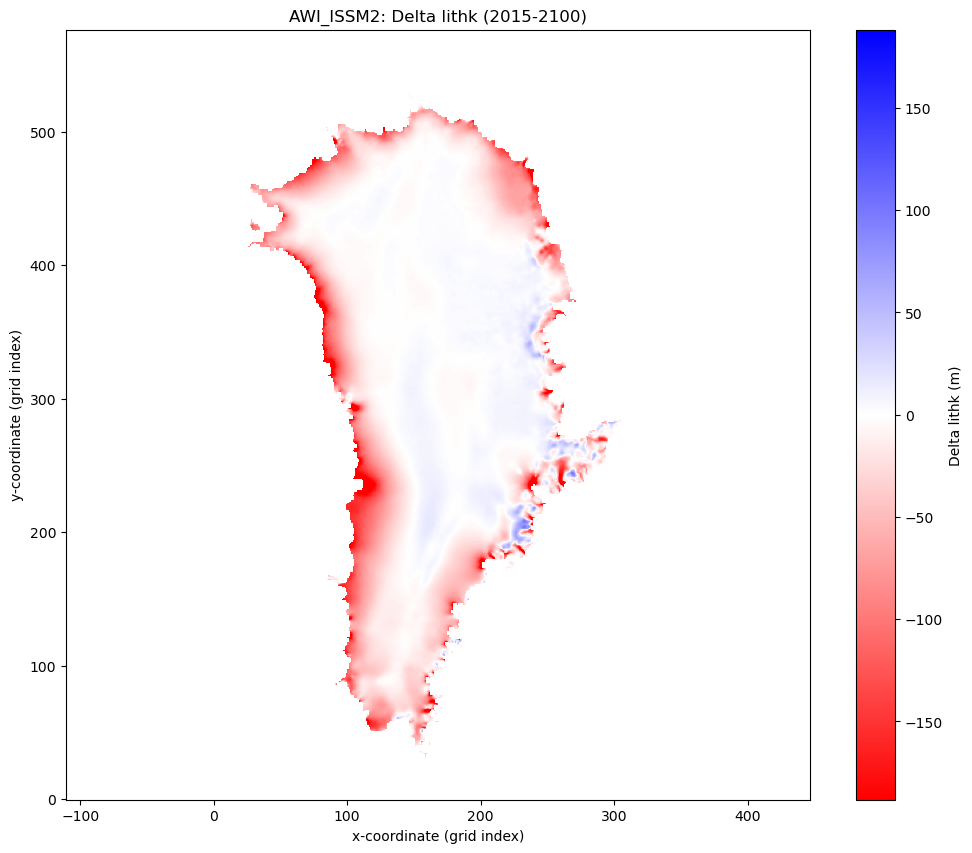

In [3]:
# --- 1. Define Paths and Variables ---
# IMPORTANT: base_dir should point to the folder containing your model NetCDF files
base_dir = r"C:\Users\benra\lithk_exp05" # Path to your folder with NetCDF files
exp_id = 'exp05' # Your experiment ID
var_name = 'lithk' # Variable name

# Define time windows (decades as suggested)
time_windows = {
    '2015-2025': (0, 10),    # indices for 2015-2025
    '2015-2035': (0, 20),    # indices for 2015-2035  
    '2015-2045': (0, 30),    # indices for 2015-2045
    '2015-2055': (0, 40),    # indices for 2015-2055
    '2015-2065': (0, 50),    # indices for 2015-2065
    '2015-2075': (0, 60),    # indices for 2015-2075
    '2015-2085': (0, 70),    # indices for 2015-2085
    '2015-2100': (0, 85)     # full time series
}

# --- 2. Dynamically Identify Models and Load Grid Dimensions (from lithk variable directly) ---
all_files_in_dir = os.listdir(base_dir)

models = [] # This will store just the model names
model_filepaths = [] # This will store the full paths to each model's NetCDF file
filename_pattern = re.compile(rf"^{var_name}_GIS_(.*)_{exp_id}\.nc$")

print(f"Scanning directory: {base_dir} for model files matching '{var_name}_GIS_MODELNAME_{exp_id}.nc'...")
for filename in sorted(all_files_in_dir): # Sort for consistent order
    match = filename_pattern.match(filename)
    if match:
        model_name = match.group(1) # Extract the MODELNAME part
        models.append(model_name)
        model_filepaths.append(os.path.join(base_dir, filename))

if not models:
    print(f"Error: No model NetCDF files found in '{base_dir}' matching the pattern '{var_name}_GIS_MODELNAME_{exp_id}.nc'.")
    print("Please ensure 'base_dir', 'var_name', and 'exp_id' are correct, and files follow the expected naming convention.")
    exit()

print(f"Found {len(models)} model files.")

# Load Grid Dimensions (rows, cols) directly from the first lithk data variable
rows, cols = None, None

first_model_filepath_for_dims = model_filepaths[0] # Use the path of the first found model
print(f"\nAttempting to load grid dimensions from: {first_model_filepath_for_dims}")
try:
    with xr.open_dataset(first_model_filepath_for_dims) as temp_ds:
        if var_name in temp_ds:
            # Get dimensions directly from the lithk variable itself
            # Assuming lithk has dimensions (time, y, x)
            lithk_dims = temp_ds[var_name].dims
            lithk_shape = temp_ds[var_name].shape

            # Find 'y' and 'x' dimensions by their names from the lithk variable's dims
            # Or by their position if naming isn't strictly 'y' and 'x' but they are always 2nd and 3rd spatial dims
            y_dim_index = lithk_dims.index('y') if 'y' in lithk_dims else 1 # Assuming 'y' is the 2nd dim if time is 0th
            x_dim_index = lithk_dims.index('x') if 'x' in lithk_dims else 2 # Assuming 'x' is the 3rd dim if time is 0th

            rows = lithk_shape[y_dim_index]
            cols = lithk_shape[x_dim_index]
            
            print(f"Grid dimensions loaded: {rows} rows, {cols} cols (from {models[0]}'s '{var_name}' variable).")
        else:
            raise ValueError(f"Variable '{var_name}' not found in {os.path.basename(first_model_filepath_for_dims)}. Cannot determine grid dimensions.")
            
except Exception as e:
    print(f"FATAL ERROR: Could not load grid dimensions from {os.path.basename(first_model_filepath_for_dims)}: {e}")
    print(f"Please inspect this NetCDF file to confirm the '{var_name}' variable exists and has spatial dimensions (y,x).")
    exit()

# --- 3. Prompt User for Model and Time Window ---
print("\n--- Plotting Individual Model Delta (Change from Initial State) ---")

# Display available models for the user
print("\nAvailable Models (derived from filenames):")
for i, model_name in enumerate(models):
    print(f"  {i+1}. {model_name}")

chosen_model_name = input("\nEnter the full name of the model you want to plot (e.g., 'AWI_ISSM1'): ").strip()

if chosen_model_name not in models:
    print(f"Error: Model '{chosen_model_name}' not found in the list of available models.")
    exit()

# Get the file path for the chosen model
chosen_model_filepath = model_filepaths[models.index(chosen_model_name)]

# Display available time windows for the user
print("\nAvailable Time Windows for Delta Calculation:")
for label in time_windows.keys():
    print(f"  - {label}")

chosen_time_window_label = input("Enter the time window label (e.g., '2015-2100'): ").strip()

if chosen_time_window_label not in time_windows:
    print(f"Error: Time window '{chosen_time_window_label}' not found.")
    exit()

start_idx, end_idx = time_windows[chosen_time_window_label]

# --- 4. Calculate Delta and Plot (Data is loaded here for the *selected* model only) ---
print(f"\nLoading data for '{chosen_model_name}' and calculating delta for {chosen_time_window_label}...")

try:
    with xr.open_dataset(chosen_model_filepath) as model_ds:
        if var_name in model_ds:
            model_data_xr = model_ds[var_name]
        else:
            raise ValueError(f"Variable '{var_name}' not found in {os.path.basename(chosen_model_filepath)}. Please check its name.")

        # Ensure enough timesteps exist in the file
        num_timesteps_in_file = len(model_data_xr['time'])
        if end_idx >= num_timesteps_in_file:
            print(f"Error: End index {end_idx} for window '{chosen_time_window_label}' is out of bounds for {chosen_model_name} (max index is {num_timesteps_in_file - 1}).")
            exit()
        
        if start_idx >= num_timesteps_in_file: # Also check start index
            print(f"Error: Start index {start_idx} for window '{chosen_time_window_label}' is out of bounds for {chosen_model_name}.")
            exit()

        # Initial state (timestep 0). This will be a 2D (y, x) array.
        initial_lithk_2d = model_data_xr.isel(time=0).values

        # Final state for the chosen time window. This will also be a 2D (y, x) array.
        final_lithk_for_window_2d = model_data_xr.isel(time=end_idx).values

        # Calculate delta. The result is already a 2D (y, x) array.
        delta_lithk_2d = final_lithk_for_window_2d - initial_lithk_2d

except Exception as e:
    print(f"ERROR: Failed to load data or calculate delta for {chosen_model_name}: {e}")
    exit()

# Plotting the delta
plt.figure(figsize=(12, 10)) # Slightly larger figure for delta plot

# --- MODIFIED VMIN/VMAX CALCULATION ---
# Calculate the 99th percentile of the absolute values of the delta data
# This provides a robust upper bound for the color scale, ignoring extreme outliers
upper_percentile_val = np.nanpercentile(np.abs(delta_lithk_2d), 99) if not np.all(np.isnan(delta_lithk_2d)) else 0

vmin_delta = -upper_percentile_val
vmax_delta = upper_percentile_val

# Fallback for cases where the percentile value is zero (e.g., all deltas are zero or NaN)
if np.isnan(upper_percentile_val) or upper_percentile_val == 0:
    vmin_delta = -100 # Default range if no meaningful delta or all NaN
    vmax_delta = 100
    print("Warning: Calculated delta range is effectively zero or NaN. Using default colorbar range (-100 to 100).")

# Use TwoSlopeNorm for a diverging colormap centered at zero
norm = TwoSlopeNorm(vmin=vmin_delta, vcenter=0, vmax=vmax_delta)

# Directly plot the 2D delta_lithk_2d array
im = plt.imshow(delta_lithk_2d, cmap='bwr_r', origin='lower', norm=norm) # RdBu_r: red for negative (thinning), blue for positive (thickening)
plt.colorbar(im, label=f'Delta {var_name} (m)') # Label indicates change in meters
plt.xlabel('x-coordinate (grid index)')
plt.ylabel('y-coordinate (grid index)')
plt.title(f'{chosen_model_name}: Delta {var_name} ({chosen_time_window_label})')
plt.axis('equal') # Ensures correct aspect ratio
plt.grid(False)
plt.show()

In [ ]:
# Mask implementation

# --- 1. Define Paths and Variables ---
# IMPORTANT: base_dir should point to the folder containing your model NetCDF files
base_dir = r"C:\Users\benra\lithk_exp05" # Path to your folder with NetCDF files
exp_id = 'exp05' # Your experiment ID
var_name = 'lithk' # Variable name

# Define time windows (decades as suggested)
time_windows = {
    '2015-2025': (0, 10),    # indices for 2015-2025
    '2015-2035': (0, 20),    # indices for 2015-2035  
    '2015-2045': (0, 30),    # indices for 2015-2045
    '2015-2055': (0, 40),    # indices for 2015-2055
    '2015-2065': (0, 50),    # indices for 2015-2065
    '2015-2075': (0, 60),    # indices for 2015-2075
    '2015-2085': (0, 70),    # indices for 2015-2085
    '2015-2100': (0, 85)     # full time series
}

# --- 2. Dynamically Identify Models and Load Grid Dimensions ---
all_files_in_dir = os.listdir(base_dir)

models = [] # This will store just the model names
model_filepaths = [] # This will store the full paths to each model's NetCDF file
filename_pattern = re.compile(rf"^{var_name}_GIS_(.*)_{exp_id}\.nc$")

print(f"Scanning directory: {base_dir} for model files matching '{var_name}_GIS_MODELNAME_{exp_id}.nc'...")
for filename in sorted(all_files_in_dir): # Sort for consistent order
    match = filename_pattern.match(filename)
    if match:
        model_name = match.group(1) # Extract the MODELNAME part
        models.append(model_name)
        model_filepaths.append(os.path.join(base_dir, filename))

if not models:
    print(f"Error: No model NetCDF files found in '{base_dir}' matching the pattern '{var_name}_GIS_MODELNAME_{exp_id}.nc'.")
    print("Please ensure 'base_dir', 'var_name', and 'exp_id' are correct, and files follow the expected naming convention.")
    exit()

print(f"Found {len(models)} model files.")

# Load Grid Dimensions (rows, cols) directly from the first lithk data variable
rows, cols = None, None

first_model_filepath_for_dims = model_filepaths[0] # Use the path of the first found model
print(f"\nAttempting to load grid dimensions from: {first_model_filepath_for_dims}")
try:
    with xr.open_dataset(first_model_filepath_for_dims) as temp_ds:
        if var_name in temp_ds:
            lithk_dims = temp_ds[var_name].dims
            lithk_shape = temp_ds[var_name].shape

            y_dim_index = lithk_dims.index('y') if 'y' in lithk_dims else 1 
            x_dim_index = lithk_dims.index('x') if 'x' in lithk_dims else 2 

            rows = lithk_shape[y_dim_index]
            cols = lithk_shape[x_dim_index]
            
            print(f"Grid dimensions loaded: {rows} rows, {cols} cols (from {models[0]}'s '{var_name}' variable).")
        else:
            raise ValueError(f"Variable '{var_name}' not found in {os.path.basename(first_model_filepath_for_dims)}. Cannot determine grid dimensions.")
            
except Exception as e:
    print(f"FATAL ERROR: Could not load grid dimensions from {os.path.basename(first_model_filepath_for_dims)}: {e}")
    print(f"Please inspect this NetCDF file to confirm the '{var_name}' variable exists and has spatial dimensions (y,x).")
    exit()

# --- NEW: Load Basin Mask Data (Global variable, loaded once) ---
mask_filepath = r"C:\Users\benra\ISMIP6_Extensions_05000m.nc"
basin_mask_data = None
try:
    with xr.open_dataset(mask_filepath) as mask_ds:
        # Assuming the mask variable is named 'IDs' and has dimensions y1, x1
        if 'IDs' in mask_ds:
            basin_mask_data = mask_ds['IDs'].values
            # Verify mask dimensions match expected rows/cols
            if basin_mask_data.shape != (rows, cols): 
                print(f"Warning: Basin mask dimensions {basin_mask_data.shape} do not match data dimensions {(rows, cols)}. This might cause misalignment.")
                # You might need to resize the mask here if misalignment is critical
        else:
            print(f"Error: Mask variable 'IDs' not found in {os.path.basename(mask_filepath)}. Basin contours will not be plotted.")
            basin_mask_data = None # Ensure it's None if not found
except Exception as e:
    print(f"Warning: Could not load basin mask from {mask_filepath}: {e}. Basin contours will not be plotted.")
    basin_mask_data = None # Ensure it's None if loading fails

# --- 3. Prompt User for Model and Time Window ---
print("\n--- Plotting Individual Model Delta (Change from Initial State) ---")

# Display available models for the user
print("\nAvailable Models (derived from filenames):")
for i, model_name in enumerate(models):
    print(f"  {i+1}. {model_name}")

chosen_model_name = input("\nEnter the full name of the model you want to plot (e.g., 'AWI_ISSM1'): ").strip()

if chosen_model_name not in models:
    print(f"Error: Model '{chosen_model_name}' not found in the list of available models.")
    exit()

# Get the file path for the chosen model
chosen_model_filepath = model_filepaths[models.index(chosen_model_name)]

# Display available time windows for the user
print("\nAvailable Time Windows for Delta Calculation:")
for label in time_windows.keys():
    print(f"  - {label}")

chosen_time_window_label = input("Enter the time window label (e.g., '2015-2100'): ").strip()

if chosen_time_window_label not in time_windows:
    print(f"Error: Time window '{chosen_time_window_label}' not found.")
    exit()

start_idx, end_idx = time_windows[chosen_time_window_label]

# --- 4. Calculate Delta and Plot (Data is loaded here for the *selected* model only) ---
print(f"\nLoading data for '{chosen_model_name}' and calculating delta for {chosen_time_window_label}...")

try:
    with xr.open_dataset(chosen_model_filepath) as model_ds:
        if var_name in model_ds:
            model_data_xr = model_ds[var_name]
        else:
            raise ValueError(f"Variable '{var_name}' not found in {os.path.basename(chosen_model_filepath)}. Please check its name.")

        num_timesteps_in_file = len(model_data_xr['time'])
        if end_idx >= num_timesteps_in_file:
            print(f"Error: End index {end_idx} for window '{chosen_time_window_label}' is out of bounds for {chosen_model_name} (max index is {num_timesteps_in_file - 1}).")
            exit()
        
        if start_idx >= num_timesteps_in_file: 
            print(f"Error: Start index {start_idx} for window '{chosen_time_window_label}' is out of bounds for {chosen_model_name}.")
            exit()

        initial_lithk_2d = model_data_xr.isel(time=0).values
        final_lithk_for_window_2d = model_data_xr.isel(time=end_idx).values
        delta_lithk_2d = final_lithk_for_window_2d - initial_lithk_2d

except Exception as e:
    print(f"ERROR: Failed to load data or calculate delta for {chosen_model_name}: {e}")
    exit()

# Plotting the delta
plt.figure(figsize=(12, 10)) 

upper_percentile_val = np.nanpercentile(np.abs(delta_lithk_2d), 99) if not np.all(np.isnan(delta_lithk_2d)) else 0
vmin_delta = -upper_percentile_val
vmax_delta = upper_percentile_val

if np.isnan(upper_percentile_val) or upper_percentile_val == 0:
    vmin_delta = -100 
    vmax_delta = 100
    print("Warning: Calculated delta range is effectively zero or NaN. Using default colorbar range (-100 to 100).")

norm = TwoSlopeNorm(vmin=vmin_delta, vcenter=0, vmax=vmax_delta)

im = plt.imshow(delta_lithk_2d, cmap='bwr_r', origin='lower', norm=norm) 
plt.colorbar(im, label=f'Delta {var_name} (m)') 
plt.xlabel('x-coordinate (grid index)')
plt.ylabel('y-coordinate (grid index)')
plt.title(f'{chosen_model_name}: Delta {var_name} ({chosen_time_window_label})')

# --- NEW: Overlay Basin Contours on Delta Plot ---
if basin_mask_data is not None:
    # Levels are set to draw contours at the half-integer boundaries between basins
    plt.contour(basin_mask_data, levels=np.arange(0.5, 26.5, 1), colors='k', linewidths=0.5, origin='lower')
    print("Basin contours overlaid on delta plot.")
else:
    print("Basin contours could not be overlaid (mask not loaded).")

plt.axis('equal') 
plt.grid(False)
plt.show()

print("\nIndividual model delta plot generated successfully!")